# MNIST LeNet

In [78]:
%matplotlib inline
import hashlib
import os
import pickle
from urllib.request import urlretrieve
import random

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from sklearn.utils import shuffle
from tqdm import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
print('All modules imported.')

All modules imported.


In [3]:
import tensorflow as tf

## Dataset

In [4]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', 'notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', 'notMNIST_test.zip')

# Make sure the files aren't corrupted
assert hashlib.md5(open('notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

All files downloaded.


In [5]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')

# Limit the amount of data to work with a docker container
docker_size_limit = 150000 #500,000 training images
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

100%|███████████████████████████████████████| 10001/10001 [00:02<00:00, 4018.45files/s]


All features and labels uncompressed.


In [89]:
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
print(train_features.shape, train_labels.shape)

100%|█████████████████████████████████████| 210001/210001 [00:49<00:00, 4225.56files/s]


MemoryError: 

### Explore the data

In [74]:
print("train_features", train_features.shape)
print("Training Image", train_features[2].shape)
print("train_labels", train_labels.shape)

train_features (142500, 784)
Training Image (784,)
train_labels (142500, 10)


[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]


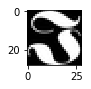

In [75]:
index = random.randint(0, len(train_features))
image = train_features[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image.reshape((28,28)), cmap="gray")
print(train_labels[index])

## Preprocess the Data

Shuffle

In [79]:
train_features, train_labels = shuffle(train_features, train_labels)

Normalize the data

In [12]:
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    Xmin = np.min(image_data) #0
    Xmax = np.max(image_data) #255
    a = 0.1
    b = 0.9
    #print("Xmin:", Xmin, "Xmax:", Xmax)
    return a + (((image_data-Xmin)*(b-a))/(Xmax- Xmin))

if not is_features_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True

One Hot Encode Labels

In [13]:
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)
    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True


In [14]:
assert is_features_normal, 'You skipped the step to normalize the features'
assert is_labels_encod, 'You skipped the step to One-Hot Encode the labels'

# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


Save the Data

In [19]:
# Save the data for easy access
pickle_file = 'notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


## Create Checkpoint

In [20]:
# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = 'notMNIST.pickle'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  train_features = pickle_data['train_dataset']
  train_labels = pickle_data['train_labels']
  valid_features = pickle_data['valid_dataset']
  valid_labels = pickle_data['valid_labels']
  test_features = pickle_data['test_dataset']
  test_labels = pickle_data['test_labels']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

Data and modules loaded.


In [68]:
print("Dataset Stats")
print("train_features: ", train_features.shape)
print("valid_features: ", valid_features.shape)
print("test_features: ", test_features.shape)
assert(len(train_features) == len(train_labels))
assert(len(test_features) == len(test_labels))
assert(len(valid_features) == len(valid_labels))

Dataset Stats
train_features:  (142500, 784)
valid_features:  (7500, 784)
test_features:  (10000, 784)


## Parameters

In [33]:
# Parameters
learning_rate = 0.00001
epochs = 10
batch_size = 128

# Number of samples to calculate validation and accuracy
# Decrease this if you're running out of memory to calculate accuracy
test_valid_size = 256

# Network Parameters
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.75  # Dropout, probability to keep units

## Weights and Biases

In [46]:
# Store layers weight & bias
mean_wt = 0 
stanDev = 0.1

weights = {
    'wc1': tf.Variable(tf.truncated_normal([5, 5, 1, 6], mean=mean_wt, stddev=stanDev)),
    'wc2': tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mean_wt, stddev=stanDev)),
    'fc1': tf.Variable(tf.truncated_normal([400, 120], mean_wt, stddev=stanDev)),
    'fc2': tf.Variable(tf.truncated_normal([120, 84], mean_wt, stddev=stanDev)),
    'out': tf.Variable(tf.truncated_normal([84, n_classes], mean_wt, stddev=stanDev))
}

biases = {
    'bc1': tf.Variable(tf.zeros(6)),
    'bc2': tf.Variable(tf.zeros(16)),
    'bf1': tf.Variable(tf.zeros(120)),
    'bf2': tf.Variable(tf.zeros(84)),
    'out': tf.Variable(tf.zeros(n_classes))
}

strides ={
    'conv1': [1,1,1,1],
    'maxPool1':[1,2,2,1],
    'conv2' : [1,1,1,1],
    'maxPool2':[1,2,2,1]
}

filters ={
    'maxPool1': [1,2,2,1],
    'maxPool2': [1,2,2,1]
}

## Variables

In [57]:
# MNIST consists of 28x28x1, grayscale images
x = tf.placeholder(tf.float32, (None, 784))
# Classify over 10 digits 0-9
y = tf.placeholder(tf.float32, (None, 10))
keep_prob = tf.placeholder(tf.float32)

# NETWORK

In [50]:
def LeNet(x, weights, biases, strides, filters):
    # from 2D (784,1) To 4D
    x = tf.reshape(x,(-1,28,28,1))
    # Add padding to width and height keeping 0 for other dimensions
    x = tf.pad(x, [[0,0], [2,2], [2,2],[0,0]], mode="CONSTANT")
    ### Layer 1 ###
    # convolution
    conv_layer1 = tf.nn.conv2d(x, weights['wc1'], strides=strides['conv1'],padding='VALID') + biases['bc1']
    # activation
    conv_layer1 = tf.nn.relu(conv_layer1)
    # pooling
    conv_layer1 = tf.nn.max_pool(conv_layer1, ksize=filters['maxPool1'],strides=strides['maxPool1'],padding='VALID')
    ### Layer 2 ###
    # convolution
    conv_layer2 = tf.nn.conv2d(conv_layer1, weights['wc2'], strides=strides['conv2'], padding='VALID') + biases['bc2']
    # activation
    conv_layer2 = tf.nn.relu(conv_layer2)
    # pooling
    conv_layer2 = tf.nn.max_pool(conv_layer2, ksize=filters['maxPool2'],strides=strides['maxPool2'],padding='VALID')
    ### Layer 3 ###
    # flatten
    flatten = tf.contrib.layers.flatten(conv_layer2)
    ### Layer 4 ###
    # fully connected
    fc1 = tf.matmul(flatten, weights['fc1']) + biases['bf1']
    # activation
    fc1 = tf.nn.relu(fc1)
    ### Layer 5 ###
    # fully connected
    fc2 = tf.matmul(fc1, weights['fc2']) + biases['bf2']
    # activation
    fc2 = tf.nn.relu(fc2)
    ### Layer 6 ###
     # fully connected
    logits = tf.matmul(fc2, weights['out']) + biases['out']
    
    return logits

## Training Pipeline

In [84]:
logits = LeNet(x, weights, biases, strides, filters)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer()
train_op = opt.minimize(cost)

## Model Evaluation

In [85]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [82]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Train the Model

In [58]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [87]:
train_features.shape[0]//batch_size

2850

In [86]:
# Initializing the variables
init = tf. global_variables_initializer()

# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    num_examples = len(train_features)
    
    print('Training on', num_examples, 'Samples...')
    print()
    
    for epoch in range(epochs):
        for batch in range(train_features.shape[0]//batch_size):
            batch_x, batch_y = next_batch(batch_size, train_features, train_labels)
            sess.run(train_op, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: 0.5})

            # Calculate batch loss and accuracy
            loss = sess.run(cost, feed_dict={
                x: batch_x,
                y: batch_y,
                keep_prob: 1.})
            valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})

            print('Epoch {:>2}, Batch {:>3} -'
                  'Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                epoch + 1,
                batch + 1,
                loss,
                valid_acc))

    # Calculate Test Accuracy
    test_acc = sess.run(accuracy, feed_dict={
        x: test_features,
        y: test_labels,
        keep_prob: 1.})
    print('Testing Accuracy: {}'.format(test_acc))

Training on 142500 Samples...

Epoch  1, Batch   1 -Loss:     2.2075 Validation Accuracy: 0.163867
Epoch  1, Batch   2 -Loss:     2.1926 Validation Accuracy: 0.186133
Epoch  1, Batch   3 -Loss:     2.2026 Validation Accuracy: 0.211067
Epoch  1, Batch   4 -Loss:     2.2320 Validation Accuracy: 0.225200
Epoch  1, Batch   5 -Loss:     2.1103 Validation Accuracy: 0.236533
Epoch  1, Batch   6 -Loss:     2.1312 Validation Accuracy: 0.242000
Epoch  1, Batch   7 -Loss:     2.1551 Validation Accuracy: 0.255467
Epoch  1, Batch   8 -Loss:     2.0899 Validation Accuracy: 0.294533
Epoch  1, Batch   9 -Loss:     2.1177 Validation Accuracy: 0.325733
Epoch  1, Batch  10 -Loss:     1.9691 Validation Accuracy: 0.348400
Epoch  1, Batch  11 -Loss:     2.0976 Validation Accuracy: 0.336800
Epoch  1, Batch  12 -Loss:     1.9667 Validation Accuracy: 0.322667
Epoch  1, Batch  13 -Loss:     1.9733 Validation Accuracy: 0.294800
Epoch  1, Batch  14 -Loss:     1.9204 Validation Accuracy: 0.302000
Epoch  1, Batch  

KeyboardInterrupt: 

In [55]:
def eval_data(dataset):
    """
    Given a dataset as input returns the loss and accuracy.
    """
    # If dataset.num_examples is not divisible by BATCH_SIZE
    # the remainder will be discarded.
    # Ex: If BATCH_SIZE is 64 and training set has 55000 examples
    # steps_per_epoch = 55000 // 64 = 859
    # num_examples = 859 * 64 = 54976
    #
    # So in that case we go over 54976 examples instead of 55000.
    steps_per_epoch = dataset.num_examples // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    total_acc, total_loss = 0, 0
    sess = tf.get_default_session()
    for step in range(steps_per_epoch):
        batch_x, batch_y = dataset.next_batch(BATCH_SIZE)
        loss, acc = sess.run([loss_op, accuracy_op], feed_dict={x: batch_x, y: batch_y})
        total_acc += (acc * batch_x.shape[0])
        total_loss += (loss * batch_x.shape[0])
    return total_loss/num_examples, total_acc/num_examples

In [56]:
if __name__ == '__main__':
    # Load data
    #mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        steps_per_epoch = mnist.train.num_examples // BATCH_SIZE
        num_examples = steps_per_epoch * BATCH_SIZE

        # Train model
        for i in range(EPOCHS):
            for step in range(steps_per_epoch):
                batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
                loss = sess.run(train_op, feed_dict={x: batch_x, y: batch_y})

            val_loss, val_acc = eval_data(mnist.validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation loss = {:.3f}".format(val_loss))
            print("Validation accuracy = {:.3f}".format(val_acc))
            print()

        # Evaluate on the test data
        test_loss, test_acc = eval_data(mnist.test)
        print("Test loss = {:.3f}".format(test_loss))
        print("Test accuracy = {:.3f}".format(test_acc))

NameError: name 'mnist' is not defined